# Dataset and problematic

The dataset given is nammed CVE. It is available right [here](https://www.kaggle.com/datasets/andrewkronser/cve-common-vulnerabilities-and-exposures "source dataset cve"), but a clean version can be downloaded at the root of the repository.

This dataset contains several columns, each of them listing data about security breach and cyber attacks. They are nammed using their CWE name (Common Weakness Enumeration, which is a list of software vulnerabilities).

The criticity of these 90 000+ breaches is evaluated with the CVSS, which goes from 0 (no risk) to 10 (extremely critical). The Common Vulnerability Scoring System is an evaluation standard of the vulnerabilities criticity based on objective and measurable factors.

Two simple approaches are available to see what Machine Learning can do:
- regression, to try to evaluate the exact value of the CVSS
- classification, if the CVSS value is split into classes (LOW, MEDIUM, HIGH, CRITICAL for example)

In this Notebook, we will try the regressive solution, because it allows to avoid the information loss between two elements of the same class.

However, the original dataset is impossible to use, because lots of comments have been written in it, breaking the CSV format. Therefore a clean version is available at the root of the project, deleting about 2000 broken rows.

# Imports and constants
## Librairies

In [25]:
# NUMPY
import numpy as np

# STATS
import scipy.stats as stats
from scipy.stats import norm, skew, kstest

# MATPLOTLIB
import matplotlib as mlp
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline 
# plt.style.use('fivethirtyeight') 

# PLOTLY 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

# WARNINGS
import warnings
warnings.filterwarnings('ignore')

# PANDAS
import pandas as pd 
pd.set_option("display.max_rows", None, "display.max_columns", None) 

# SEABORN
import seaborn as sns

# SCIKIT-LEARN: SELECTION DE VARIABLES
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression

# SCIKIT-LEARN: PRE-PROCESSING
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder # Encodage des variables catégorielles ordinales
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder # Encodage des variables catégorielles nominales
from sklearn.preprocessing import StandardScaler # Normalisation des variables numériques
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer # Imputation
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# SCIKIT-LEARN: MODELES
from sklearn.dummy import DummyClassifier
from sklearn import linear_model # Classe Modèle linéaire 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet # Régression linéaire
from sklearn.linear_model import LogisticRegression, SGDRegressor, LinearRegression # Régression logistique
from sklearn.svm import LinearSVC, SVC, LinearSVR, SVR # Machines à vecteurs de support

# SCIKIT-LEARN: VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Découpage en données train et test
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # Tester plusieurs hyper_paramètres
from sklearn.model_selection import learning_curve # Courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
## EVALUATION
from sklearn import metrics
from sklearn.metrics import accuracy_score # Exactitude (accuracy)
from sklearn.metrics import f1_score # F1-score
from sklearn.metrics import confusion_matrix # Matrice de confusion
from sklearn.metrics import plot_confusion_matrix # Graphique de la matrice de confusion
from sklearn.metrics import classification_report # Rapport pour le modèle de classification
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

## EVALUATION: COURBE ROC
from sklearn.metrics import auc # Aire sous la courbe 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve 

# SCHIKIT-LEARN: PIPELINE et TRANSFORMATEUR
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

## ARBRES, FORETS, APRRENTISSAGE D'ENSEMBLE
from sklearn.tree import DecisionTreeClassifier # Arbres de décision (classification)
from sklearn.ensemble import RandomForestClassifier # Forêts aléatoires (classification)
from sklearn.ensemble import BaggingClassifier # Classifier Bagging (classification)
from sklearn.ensemble import AdaBoostClassifier # Classifier Adaboost (classification)
from sklearn.ensemble import GradientBoostingClassifier  # Gradient de boosting (classification)
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

# VALIDATION CROISEE + OPTIMISATION
from sklearn.model_selection import train_test_split # Séparation des données en train et test set
from sklearn.model_selection import cross_val_score # Validation croisée pour comparaison entre modèles
from sklearn.model_selection import validation_curve # Courbe de validation: visulaisr les scores lors du choix d'un hyperparamétre
from sklearn.model_selection import GridSearchCV # tester plusieurs hyperparamètres
from sklearn.model_selection import RandomizedSearchCV # tester arbitrairement plusieurs hyperparamètres
from sklearn.model_selection import learning_curve # courbe d'apprentissage: visualisation les scores du train et du validation sets en fonction des quanitiés des données
 
# WARNINGS
import warnings
warnings.filterwarnings('ignore')

## Constants definition

In [26]:
# Setting of the random state to reproduce identically tests
_RANDOM_STATE_ = 7
# Target name
targetName = 'cvss'

## Dataset import

In [27]:
dataset = pd.read_csv("cve.csv", sep = ';')

# Exploratory data analysis

In [28]:
 # Copy of the dataset
df_data = dataset.copy()

In [29]:
df_data.head()

cve          mod_date          pub_date  cvss  cwe_code  \
0  CVE-2019-16548  21/11/2019 15:15  21/11/2019 15:15   6.8       352   
1  CVE-2019-16547  21/11/2019 15:15  21/11/2019 15:15   4.0       732   
2  CVE-2019-16546  21/11/2019 15:15  21/11/2019 15:15   4.3       639   
3   CVE-2013-2092  20/11/2019 21:22  20/11/2019 21:15   4.3        79   
4   CVE-2013-2091  20/11/2019 20:15  20/11/2019 20:15   7.5        89   

                                            cwe_name  \
0                  Cross-Site Request Forgery (CSRF)   
1   Incorrect Permission Assignment for Critical ...   
2   Authorization Bypass Through User-Controlled Key   
3   Improper Neutralization of Input During Web P...   
4   Improper Neutralization of Special Elements u...   

                                             summary access_authentication  \
0  A cross-site request forgery vulnerability in ...                   NaN   
1  Missing permission checks in various API endpo...                   NaN   
2  Jenkins Google Compute Engine Plugin 4.1.1 and...                   NaN   
3  Cross-site Scripting (XSS) in Dolibarr ERP/CRM...                   NaN   
4  SQL injection vulnerability in Dolibarr ERP/CR...                   NaN   

  access_complexity access_vector impact_availability impact_confidentiality  \
0               NaN           NaN                 NaN                    NaN   
1               NaN           NaN                 NaN                    NaN   
2               NaN           NaN                 NaN                    NaN   
3               NaN           NaN                 NaN                    NaN   
4               NaN           NaN                 NaN                    NaN   

  impact_integrity  Unnamed: 13  Unnamed: 14  Unnamed: 15  Unnamed: 16  \
0              NaN          NaN          NaN          NaN          NaN   
1              NaN          NaN          NaN          NaN          NaN   
2              NaN          NaN          NaN          NaN          NaN   
3              NaN          NaN          NaN          NaN          NaN   
4              NaN          NaN          NaN          NaN          NaN   

   Unnamed: 17  Unnamed: 18  Unnamed: 19  Unnamed: 20  Unnamed: 21  \
0          NaN          NaN          NaN          NaN          NaN   
1          NaN          NaN          NaN          NaN          NaN   
2          NaN          NaN          NaN          NaN          NaN   
3          NaN          NaN          NaN          NaN          NaN   
4          NaN          NaN          NaN          NaN          NaN   

   Unnamed: 22  Unnamed: 23 Unnamed: 24 Unnamed: 25 Unnamed: 26 Unnamed: 27  \
0          NaN          NaN         NaN         NaN         NaN         NaN   
1          NaN          NaN         NaN         NaN         NaN         NaN   
2          NaN          NaN         NaN         NaN         NaN         NaN   
3          NaN          NaN         NaN         NaN         NaN         NaN   
4          NaN          NaN         NaN         NaN         NaN         NaN   

  Unnamed: 28 Unnamed: 29 Unnamed: 30 Unnamed: 31 Unnamed: 32 Unnamed: 33  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 34 Unnamed: 35 Unnamed: 36 Unnamed: 37 Unnamed: 38 Unnamed: 39  \
0         NaN         NaN         NaN         NaN         NaN         NaN   
1         NaN         NaN         NaN         NaN         NaN         NaN   
2         NaN         NaN         NaN         NaN         NaN         NaN   
3         NaN         NaN         NaN         NaN         NaN         NaN   
4         NaN         NaN         NaN         NaN         NaN         NaN   

  Unnamed: 40 Unnamed

The display of the first 5 lines of the dataset gives us an idea of its composition. Here, we notice the target, which is a floating continuous value, 'cwe_code' which is integer, and the others which seem either textual or missing.

In [30]:
# Size of the dataset
n_samples, n_features = df_data.shape
print("Rows:", n_samples)
print("Columns:", n_features)

Rows: 89531
Columns: 97


In [31]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89531 entries, 0 to 89530
Data columns (total 97 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   cve                     89531 non-null  object 
 1   mod_date                89531 non-null  object 
 2   pub_date                89531 non-null  object 
 3   cvss                    89531 non-null  float64
 4   cwe_code                89531 non-null  int64  
 5   cwe_name                89531 non-null  object 
 6   summary                 89531 non-null  object 
 7   access_authentication   85401 non-null  object 
 8   access_complexity       85401 non-null  object 
 9   access_vector           85401 non-null  object 
 10  impact_availability     85401 non-null  object 
 11  impact_confidentiality  85401 non-null  object 
 12  impact_integrity        85401 non-null  object 
 13  Unnamed: 13             0 non-null      float64
 14  Unnamed: 14             0 non-null    

Most of the columns have only a few non-zero values. They are therefore not usable as such, and we must question their usefulness. However, we can delete columns 13 to 23 which contain only null values.

In [32]:
df_data.drop(df_data.iloc[:, 13:24], inplace = True, axis = 1)

We can now observe the behavior of the variables when the features 96 is not null:

In [33]:
df_data.loc[df_data['Unnamed: 96'].notnull()].head()

cve          mod_date          pub_date  cvss  cwe_code  \
44010  CVE-2017-17144  29/03/2018 14:21  05/03/2018 19:29   5.0       119   
44089  CVE-2017-17143  27/03/2018 20:41  05/03/2018 19:29   5.0       119   
44090  CVE-2017-17142  27/03/2018 20:40  05/03/2018 19:29   5.0       119   

                                                cwe_name  \
44010   Improper Restriction of Operations within the...   
44089   Improper Restriction of Operations within the...   
44090   Improper Restriction of Operations within the...   

                                                 summary  \
44010  Backup feature of SIP module in Huawei DP300 V...   
44089             SIP module in Huawei DP300 V500R002C00   
44090             SIP module in Huawei DP300 V500R002C00   

      access_authentication access_complexity access_vector  \
44010                   NaN               NaN           NaN   
44089                   NaN               NaN           NaN   
44090                   NaN               NaN           NaN   

      impact_availability impact_confidentiality impact_integrity  \
44010                 NaN                    NaN              NaN   
44089                 NaN                    NaN              NaN   
44090                 NaN                    NaN              NaN   

              Unnamed: 24         Unnamed: 25         Unnamed: 26  \
44010   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   
44089   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   
44090   V100R001C10SPC300   V100R001C10SPC500   V100R001C10SPC600   

                  Unnamed: 27         Unnamed: 28         Unnamed: 29  \
44010   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   
44089   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   
44090   V100R001C10SPC700B010   V100R001C10SPC800   V500R002C00SPC200   

              Unnamed: 30         Unnamed: 31         Unnamed: 32  \
44010   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   
44089   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   
44090   V500R002C00SPC500   V500R002C00SPC600   V500R002C00SPC700   

              Unnamed: 33         Unnamed: 34   Unnamed: 35  \
44010   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   
44089   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   
44090   V500R002C00SPC900   V500R002C00SPCb00   V600R006C00   

                   Unnamed: 36         Unnamed: 37         Unnamed: 38  \
44010   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   
44089   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   
44090   TE40 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPC900   

              Unnamed: 39   Unnamed: 40         Unnamed: 41  \
44010   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   
44089   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   
44090   V500R002C00SPCb00   V600R006C00   V600R006C00SPC200   

                   Unnamed: 42         Unnamed: 43         Unnamed: 44  \
44010   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   
44089   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   
44090   TE50 V500R002C00SPC600   V500R002C00SPC700   V500R002C00SPCb00   

        Unnamed: 45         Unnamed: 46              Unnamed: 47  \
44010   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   
44089   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   
44090   V600R006C00   V600R006C00SPC200   TE60 V100R001C01SPC100   

                   Unnamed: 48   Unnamed: 49         Unnamed: 50  \
44010   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   
44089   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   
44090   V100R001C01SPC107TB010   V100R001C10   V100R001C10SPC300   

              Unnamed: 51         Unnamed: 52         Unnamed: 53  \
44010   V100R001C10SPC400   V100R001C10SPC500   V100R001C10SPC600   
44089   V100R001C10SPC400   V100R001C10SPC500   V100R001C10SPC600 

We notice that on the 3 non-zero rows of the feature 96, all the columns starting from 24 are filled.

## Continuous features (Target)

In [34]:
con_features = df_data.select_dtypes(include=['float64']).columns
print(con_features)

Index(['cvss'], dtype='object')


In [35]:
print(f'{np.sort(df_data[targetName].unique())}')

[ 0.   1.2  1.3  1.5  1.7  1.8  1.9  2.1  2.3  2.4  2.6  2.7  2.8  2.9
  3.   3.2  3.3  3.5  3.6  3.7  3.8  4.   4.1  4.3  4.4  4.6  4.7  4.8
  4.9  5.   5.1  5.2  5.3  5.4  5.5  5.6  5.7  5.8  5.9  6.   6.1  6.2
  6.3  6.4  6.5  6.6  6.7  6.8  6.9  7.   7.1  7.2  7.3  7.4  7.5  7.6
  7.7  7.8  7.9  8.   8.2  8.3  8.5  8.7  8.8  9.   9.3  9.4  9.7 10. ]


Only the target is a continuous column, going from 0 to 10. No transformation seems necessary to use it. However, for most Machine Learning models, it is necessary to check that the density curve of the target is approximately normal (Gaussian shape) in order to use it.

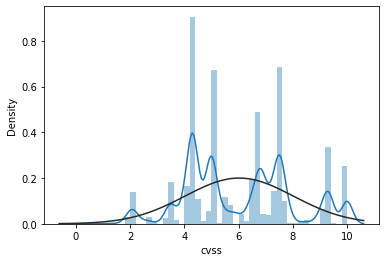

In [36]:
sns.distplot(df_data[targetName], fit=norm)

As we can see here, the target is not at all Gaussian (black curve: expected Gaussian, blue curve: target distribution). We will therefore have to try to reduce and center it with a log-transformation.

In [37]:
con_features.drop(targetName)

Index([], dtype='object')

We can remove the target from the continuous features, because we don't want to apply any pre-processing to them (scaling etc.).

## Categorical features

In [38]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns
print(cat_features)

Index(['cve', 'mod_date', 'pub_date', 'cwe_code', 'cwe_name', 'summary',
       'access_authentication', 'access_complexity', 'access_vector',
       'impact_availability', 'impact_confidentiality', 'impact_integrity',
       'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27',
       'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30', 'Unnamed: 31',
       'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47',
       'Unnamed: 48', 'Unnamed: 49', 'Unnamed: 50', 'Unnamed: 51',
       'Unnamed: 52', 'Unnamed: 53', 'Unnamed: 54', 'Unnamed: 55',
       'Unnamed: 56', 'Unnamed: 57', 'Unnamed: 58', 'Unnamed: 59',
       'Unnamed: 60', 'Unnamed: 61', 'Unnamed: 62', 'Unnamed: 63',
       'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67',
       'Unnamed: 68', 'Unnamed: 69', 'Unname

All the columns seem to be categorized but the target.

In [39]:
df_data["cwe_name"].value_counts()

 Improper Neutralization of Input During Web Page Generation ('Cross-site Scripting')           12325
 Improper Restriction of Operations within the Bounds of a Memory Buffer                        12325
 Improper Input Validation                                                                       7869
 Information Exposure                                                                            6592
 Permissions Privileges and Access Controls                                                      5813
 Improper Neutralization of Special Elements used in an SQL Command ('SQL Injection')            5740
 Improper Limitation of a Pathname to a Restricted Directory ('Path Traversal')                  3062
 Resource Management Errors                                                                      2960
 Cryptographic Issues                                                                            2552
 Cross-Site Request Forgery (CSRF)                                                

We notice that this column contains CWE names, which are therefore categories. There is no need to perform NLP on this column because these are categories that we can encode later.

In [40]:
df_data["cwe_code"].value_counts()

79      12325
119     12325
20       7869
200      6592
264      5813
89       5740
22       3062
399      2960
310      2552
352      2415
94       2412
125      2105
287      1801
284      1658
189      1363
416      1340
190      1134
476       971
255       967
787       853
78        829
362       643
400       576
254       568
59        541
77        520
434       447
732       423
611       420
295       391
269       390
74        366
798       342
772       324
426       301
601       278
502       277
16        248
19        238
134       218
835       217
918       207
704       196
522       186
415       174
17        163
532       162
863       156
275       155
384       124
326       121
369       117
285       117
120       109
862       106
306        98
276        93
347        82
770        81
319        81
617        80
129        78
427        76
668        72
345        72
327        71
320        65
404        61
640        60
311        58
191        55
388   

We notice an interesting detail in this dataset. The column 'cwe_code' is an encoding of the values of 'cwe_name'. So we can delete the non-encoded value.

In [41]:
df_data=df_data.drop(['cwe_name', ],axis=1)

In [42]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns
for feature in cat_features:
    print(f'{feature :-<30} {df_data[feature].unique()}')

cve--------------------------- ['CVE-2019-16548' 'CVE-2019-16547' 'CVE-2019-16546' ... 'CVE-2007-6442'
 'CVE-2007-6370' 'CVE-2007-3004']
mod_date---------------------- ['21/11/2019 15:15' '20/11/2019 21:22' '20/11/2019 20:15' ...
 '11/02/2008 05:00' '21/01/2008 05:00' '10/01/2008 05:00']
pub_date---------------------- ['21/11/2019 15:15' '20/11/2019 21:15' '20/11/2019 20:15' ...
 '24/07/2007 17:30' '11/04/2003 04:00' '10/01/2008 01:46']
cwe_code---------------------- [ 352  732  639   79   89  200   20  319  276  269  426   74  362  273
  416   59  611  434  287   22  295  400   78  125  190  476  532  119
  668  120  307  787  522  754  863  755  610  862  772  384  613  354
  327  290  134  617  918  415  345  494  311  502  835  674  798  824
   91  330  347  312 1188  640  916  704  601  264  306  829  129 1187
  521  338  665  331  326  776   94  294  399  404  843  254  428  552
 1021  770  669  367  255  436  191  427  444  565  284  189  310   77
  275  369  924  285  281  682 

We notice here that most of the categorical values are encodable, especially the columns 'access_authentication', 'complexity', 'access_vector', 'impact_availability', 'impact_confidentiality', and 'impact_integrity' which have few categories. On the other hand, the summary column has a lot of different values (more than 30, and almost one different value per row), which would imply the use of NLP (through an adapted neural network), so we will remove it from the dataset for the moment. If no classical regression model gives convincing results, we can wonder about using Tensorflow or a competing library.

In [43]:
df_data=df_data.drop(['summary'],axis=1)

In [44]:
dfMissvalues = pd.DataFrame(
                           (round(100* df_data.isnull().sum()/len(df_data), 2)), 
                           columns=['Percentage of missing values']
                           )
dfMissvalues.sort_values(by=['Percentage of missing values'], ascending=False)

Percentage of missing values
Unnamed: 96                                   100.00
Unnamed: 81                                   100.00
Unnamed: 66                                   100.00
Unnamed: 67                                   100.00
Unnamed: 68                                   100.00
Unnamed: 69                                   100.00
Unnamed: 70                                   100.00
Unnamed: 71                                   100.00
Unnamed: 72                                   100.00
Unnamed: 73                                   100.00
Unnamed: 74                                   100.00
Unnamed: 75                                   100.00
Unnamed: 76                                   100.00
Unnamed: 78                                   100.00
Unnamed: 79                                   100.00
Unnamed: 80                                   100.00
Unnamed: 77                                   100.00
Unnamed: 82                                   100.00
Unnamed: 89                                   100.00
Unnamed: 95                                   100.00
Unnamed: 94                                   100.00
Unnamed: 83                                   100.00
Unnamed: 92                                   100.00
Unnamed: 91                                   100.00
Unnamed: 90                                   100.00
Unnamed: 93                                   100.00
Unnamed: 88                                   100.00
Unnamed: 87                                   100.00
Unnamed: 86                                   100.00
Unnamed: 85                                   100.00
Unnamed: 84                                   100.00
Unnamed: 56                                    99.99
Unnamed: 65                                    99.99
Unnamed: 64                                    99.99
Unnamed: 63                                    99.99
Unnamed: 62                                    99.99
Unnamed: 61                                    99.99
Unnamed: 60                                    99.99
Unnamed: 59                                    99.99
Unnamed: 58                                    99.99
Unnamed: 57                                    99.99
Unnamed: 55                                    99.99
Unnamed: 34                                    99.99
Unnamed: 43                                    99.99
Unnamed: 32                                    99.99
Unnamed: 33                                    99.99
Unnamed: 54                                    99.99
Unnamed: 35                                    99.99
Unnamed: 37                                    99.99
Unnamed: 38                                    99.99
Unnamed: 39                                    99.99
Unnamed: 40                                    99.99
Unnamed: 41                                    99.99
Unnamed: 42                                    99.99
Unnamed: 36                                    99.99
Unnamed: 44                                    99.99
Unnamed: 46                                    99.99
Unnamed: 47                                    99.99
Unnamed: 48                                    99.99
Unnamed: 49                                    99.99
Unnamed: 50                                    99.99
Unnamed: 51                                    99.99
Unnamed: 52                                    99.99
Unnamed: 53                                    99.99
Unnamed: 45                                    99.99
Unnamed: 27                                    99.98
Unnamed: 24                                    99.98
Unnamed: 25                                    99.98
Unnamed: 26                                    99.98
Unnamed: 29                                    99.98
Unnamed: 28                                    99.98
Unnamed: 30                                    99.98
Unnamed: 31                                    99.98
impact_integrity                                4.61
impact_confidentiality                          4

We notice that some variables have almost 100% missing values. They are therefore not usable. Therefore, we can delete them.

In [45]:
miss_rates = df_data.isna().sum() / len(df_data)
features = df_data.columns[miss_rates  < 0.9]
df_data = df_data[features]                 

In [46]:
df_data.shape

(89531, 11)

The dataset is now much smaller, from almost 100 columns to 13. We notice however that some columns can still be deleted, like for example 'cve' which represents only the name of the CVE and thus acts as an ID.

In [47]:
df_data=df_data.drop(['cve'],axis=1)

We now need to manage the dates. Indeed, in the given format, the dates are not exploitable by our Machine Learning algorithms, and therefore cannot be taken into account in the modeling. However, we can assume that they play a more or less important role in the evaluation of the CVSS, for example if the vulnerabilities discovered at certain times of the day give a higher score on the danger of the latter.

In [48]:
# Coupage de la colonne 'mod_date'
df_data['mod_minute'] = pd.to_datetime(df_data['mod_date']).dt.minute
df_data['mod_hour'] = pd.to_datetime(df_data['mod_date']).dt.hour
df_data['mod_day'] = pd.to_datetime(df_data['mod_date']).dt.day
df_data['mod_month'] = pd.to_datetime(df_data['mod_date']).dt.month
df_data['mod_year'] = pd.to_datetime(df_data['mod_date']).dt.year
df_data = df_data.drop(['mod_date'], axis=1)

# Coupage de la colonne 'pub_date'
df_data['pub_minute'] = pd.to_datetime(df_data['pub_date']).dt.minute
df_data['pub_hour'] = pd.to_datetime(df_data['pub_date']).dt.hour
df_data['pub_day'] = pd.to_datetime(df_data['pub_date']).dt.day
df_data['pub_month'] = pd.to_datetime(df_data['pub_date']).dt.month
df_data['pub_year'] = pd.to_datetime(df_data['pub_date']).dt.year
df_data = df_data.drop(['pub_date'], axis=1)

In [49]:
df_data.head()

cvss  cwe_code access_authentication access_complexity access_vector  \
0   6.8       352                   NaN               NaN           NaN   
1   4.0       732                   NaN               NaN           NaN   
2   4.3       639                   NaN               NaN           NaN   
3   4.3        79                   NaN               NaN           NaN   
4   7.5        89                   NaN               NaN           NaN   

  impact_availability impact_confidentiality impact_integrity  mod_minute  \
0                 NaN                    NaN              NaN          15   
1                 NaN                    NaN              NaN          15   
2                 NaN                    NaN              NaN          15   
3                 NaN                    NaN              NaN          22   
4                 NaN                    NaN              NaN          15   

   mod_hour  mod_day  mod_month  mod_year  pub_minute  pub_hour  pub_day  \
0        15       21         11      2019          15        15       21   
1        15       21         11      2019          15        15       21   
2        15       21         11      2019          15        15       21   
3        21       20         11      2019          15        21       20   
4        20       20         11      2019          15        20       20   

   pub_month  pub_year  
0         11      2019  
1         11      2019  
2         11      2019  
3         11      2019  
4         11      2019

Breaking the date into multiple columns allows us to use them in our models now, as the format is compatible with modeling approaches.

In [50]:
cat_features = df_data.select_dtypes(include=['int64','object']).columns

In [51]:
print("Categorical columns:\n\n", cat_features.values)

Categorical columns:

 ['cwe_code' 'access_authentication' 'access_complexity' 'access_vector'
 'impact_availability' 'impact_confidentiality' 'impact_integrity'
 'mod_minute' 'mod_hour' 'mod_day' 'mod_month' 'mod_year' 'pub_minute'
 'pub_hour' 'pub_day' 'pub_month' 'pub_year']


In [52]:
# Dataset size
n_samples, n_features = df_data.shape
print("Rows:", n_samples)
print("Columns:", n_features)

Rows: 89531
Columns: 18


Finally, the dataframe is made of 18 columns, so the reduction is impressive compared to the initial dataset, which makes the problem more understandable.

## Missing values

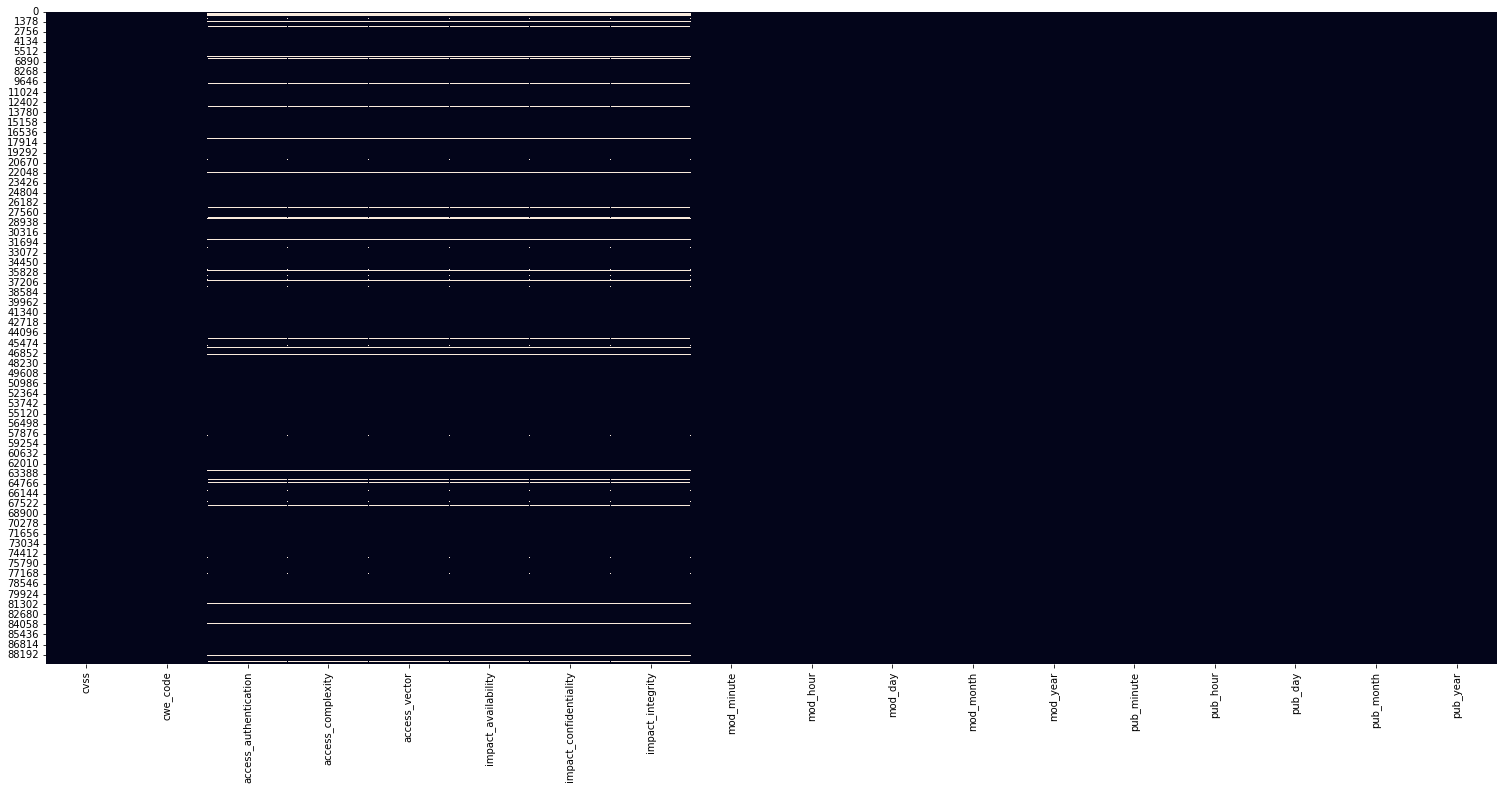

In [53]:
# Afficher tous les na
plt.figure(figsize=(26, 12))
sns.heatmap(df_data.isna(), cbar=False)
plt.show()

For the remaining columns, the missing values are quite small, and all present on 6 columns. It will be necessary to use an imputer during the pre-processing in order to fill these values with the modes or the k nearest neighbors for example.

## Bivariate analysis between the features

### Correlation between the continuous features

In [54]:
corrmat = df_data.corr()

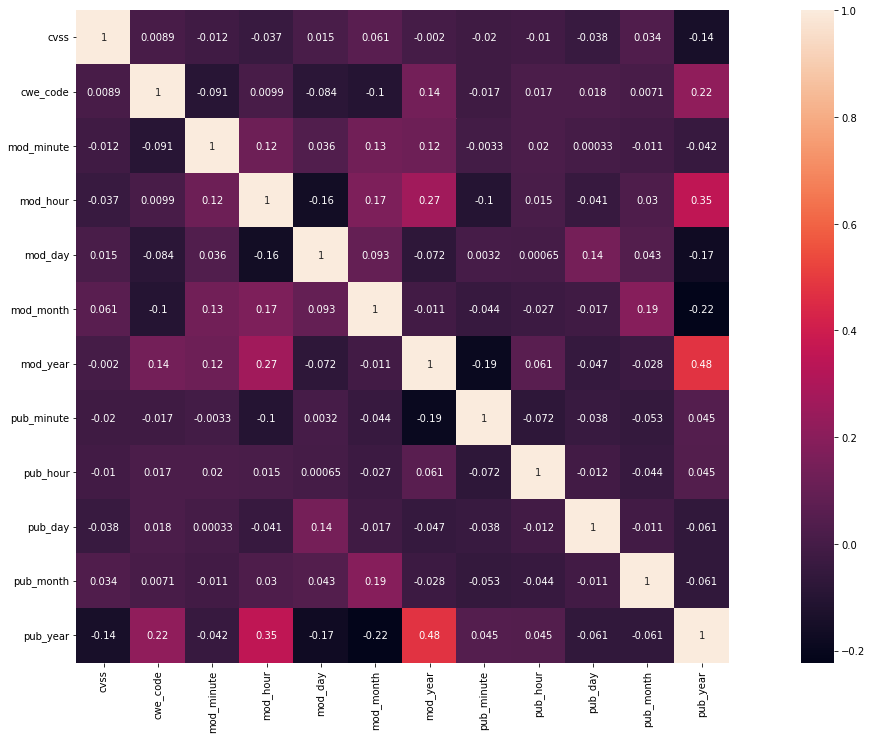

In [55]:
plt.figure(figsize=(26, 12))
sns.heatmap(corrmat, annot=True, cbar=True, square=True, vmax=1)
plt.show()

In [56]:
print(corrmat)

                cvss  cwe_code  mod_minute  mod_hour   mod_day  mod_month  \
cvss        1.000000  0.008936   -0.012434 -0.036548  0.014663   0.061450   
cwe_code    0.008936  1.000000   -0.090925  0.009906 -0.083563  -0.101448   
mod_minute -0.012434 -0.090925    1.000000  0.119121  0.035701   0.134383   
mod_hour   -0.036548  0.009906    0.119121  1.000000 -0.164237   0.165034   
mod_day     0.014663 -0.083563    0.035701 -0.164237  1.000000   0.092714   
mod_month   0.061450 -0.101448    0.134383  0.165034  0.092714   1.000000   
mod_year   -0.002000  0.136709    0.116638  0.266811 -0.071939  -0.011458   
pub_minute -0.019658 -0.017412   -0.003303 -0.100567  0.003219  -0.043743   
pub_hour   -0.010110  0.017498    0.020329  0.014949  0.000645  -0.027473   
pub_day    -0.038241  0.017597    0.000334 -0.041161  0.140743  -0.016951   
pub_month   0.033502  0.007147   -0.010573  0.030069  0.042998   0.190277   
pub_year   -0.141871  0.218662   -0.042195  0.350713 -0.173652  -0.222543   

We notice that there is no significant linear correlation between the value 'cve_code' and the target. This makes sense, because the code is only an encoded value and not a quantity. On the other hand, the columns 'mod_year' and 'pub_year' have a fairly strong linear correlation, which is quite logical. However, it is only 0.43, which means that more than half of the time there is a delay of at least one year between the publication and the modification.

### Correlation between the categorical features

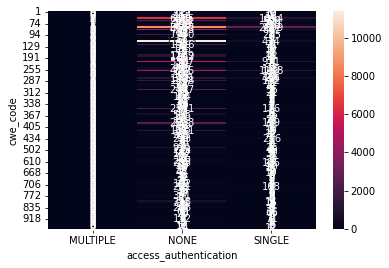

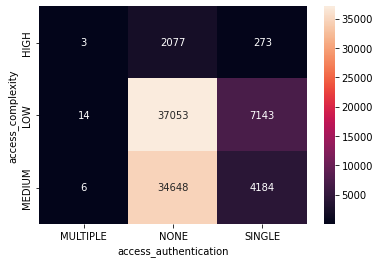

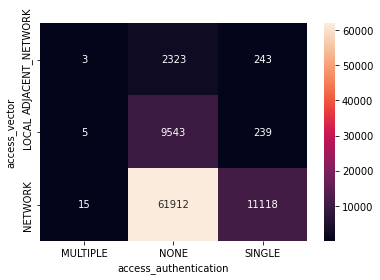

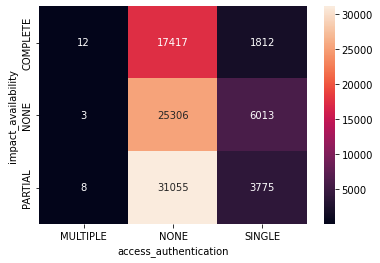

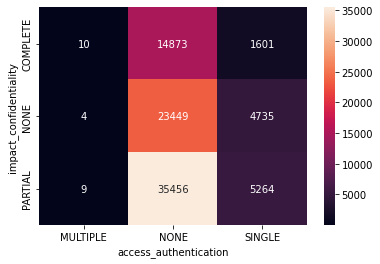

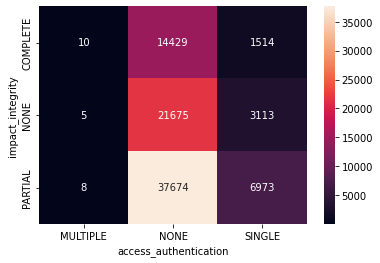

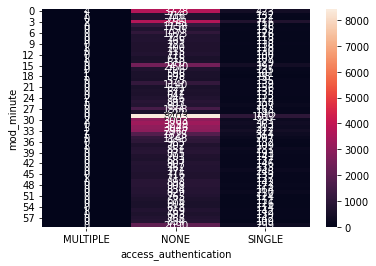

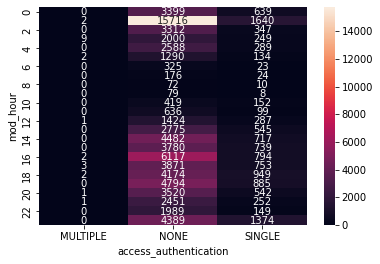

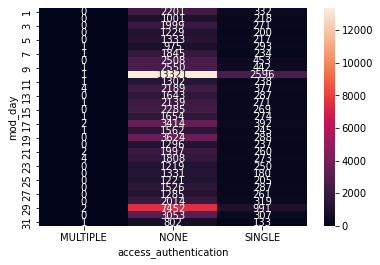

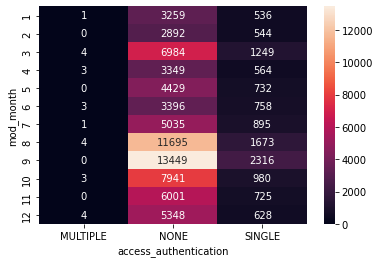

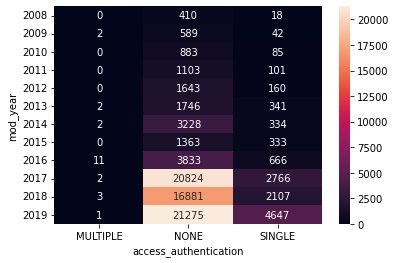

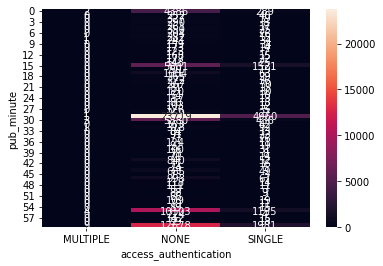

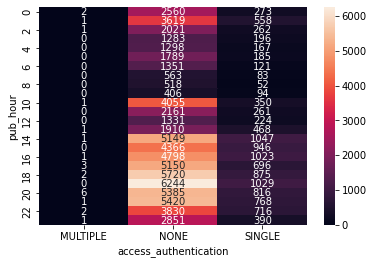

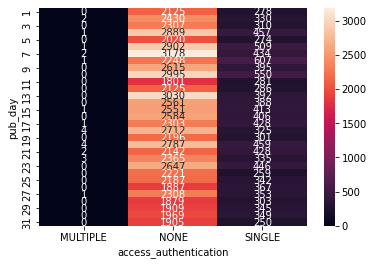

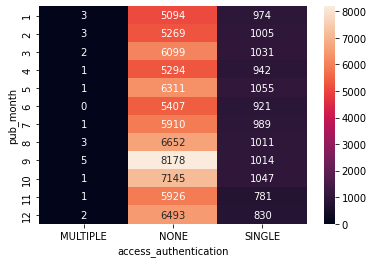

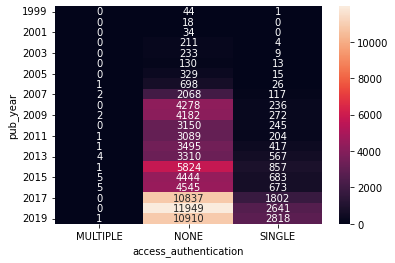

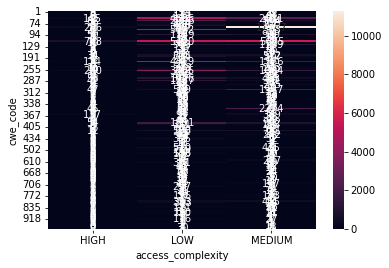

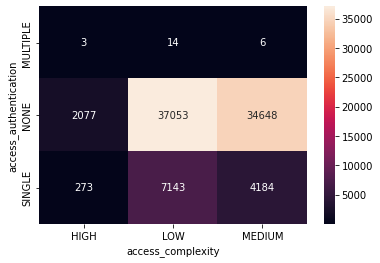

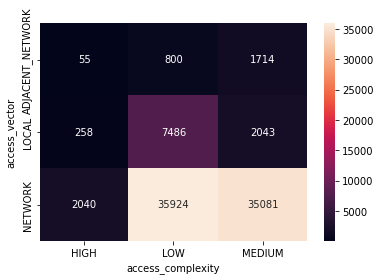

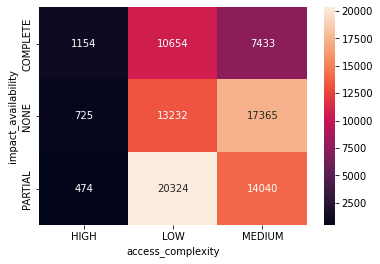

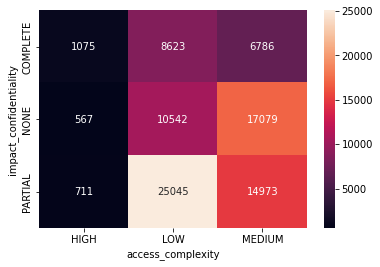

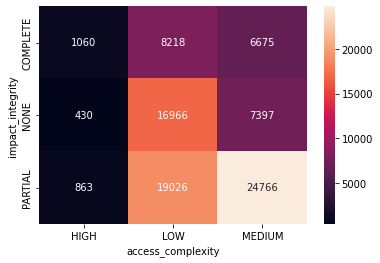

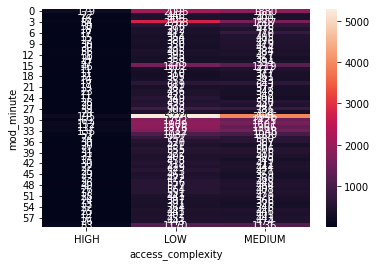

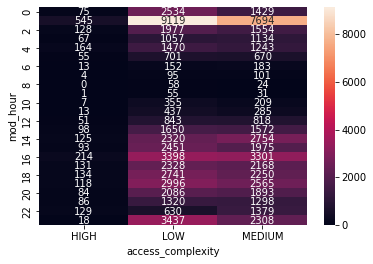

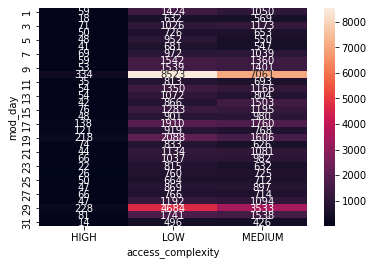

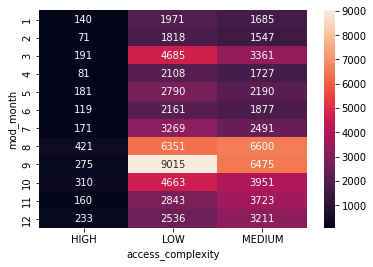

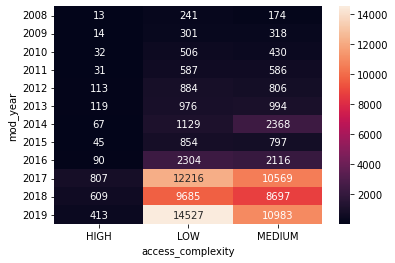

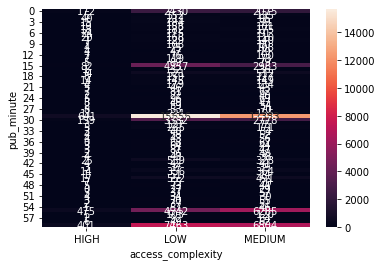

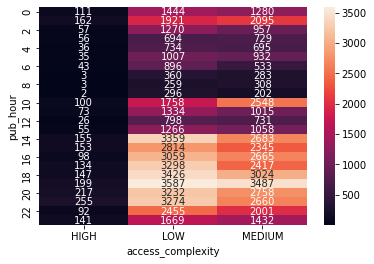

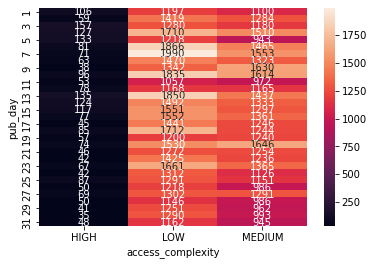

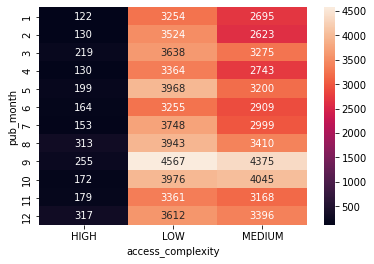

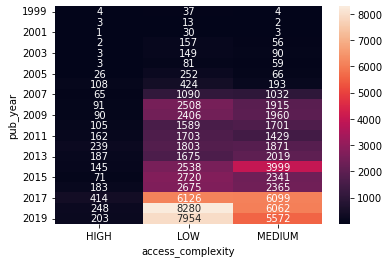

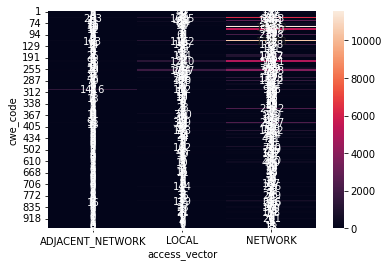

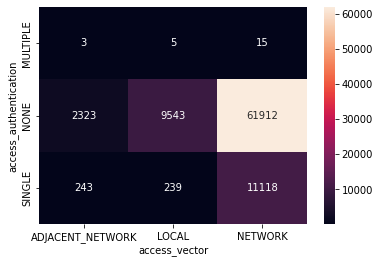

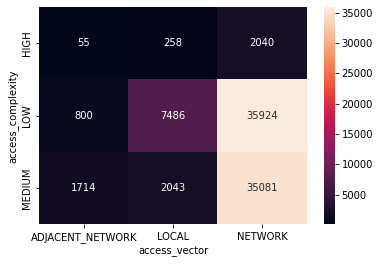

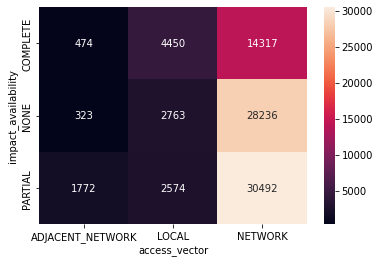

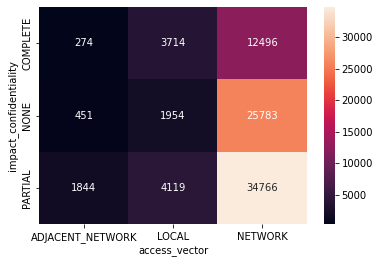

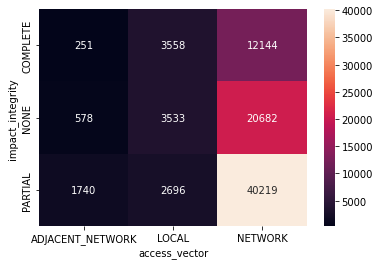

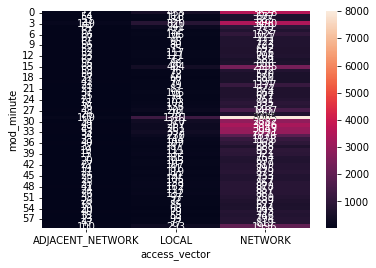

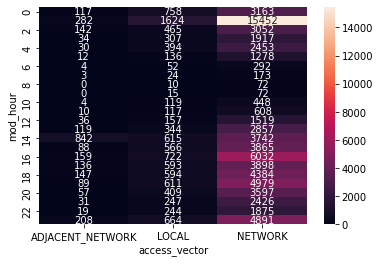

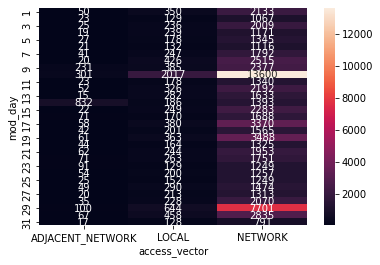

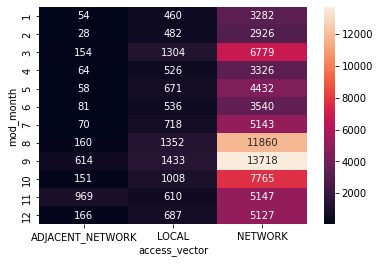

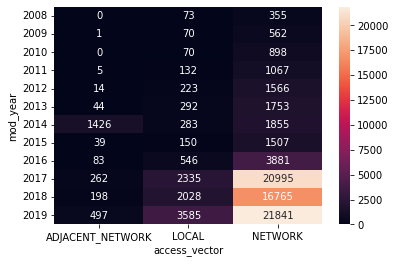

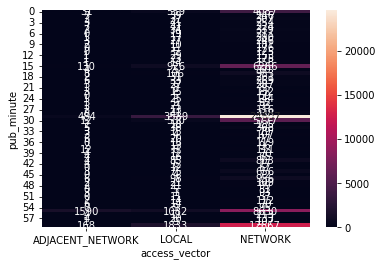

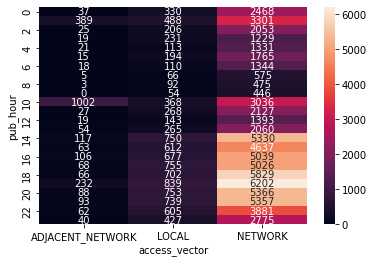

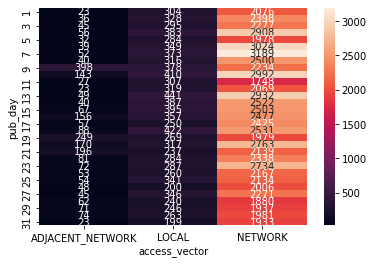

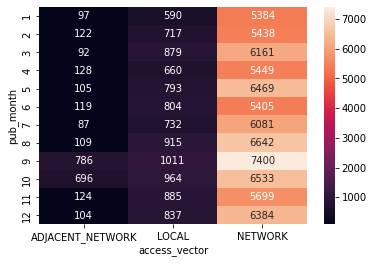

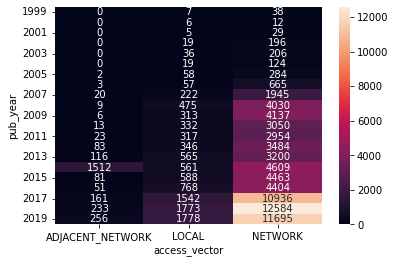

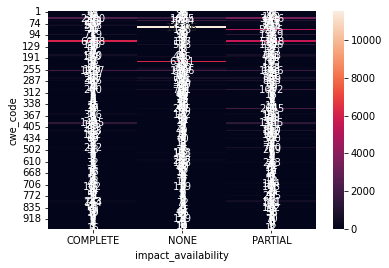

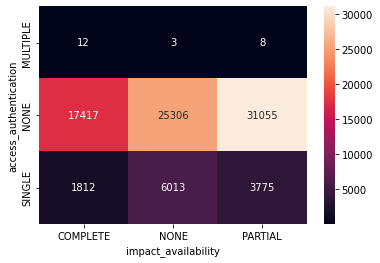

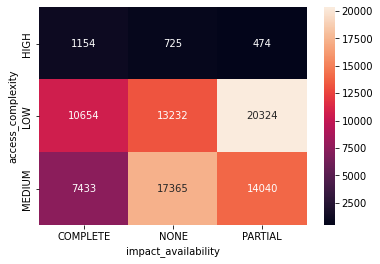

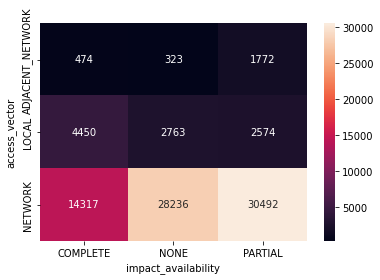

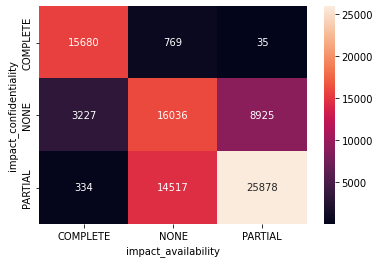

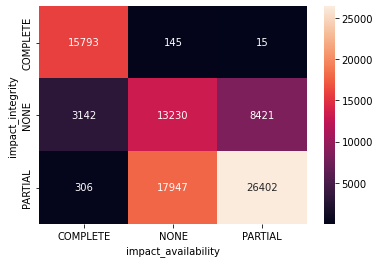

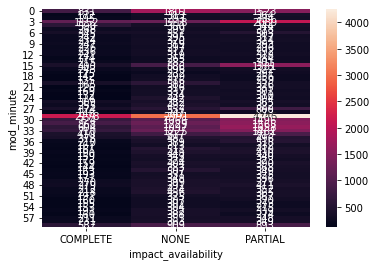

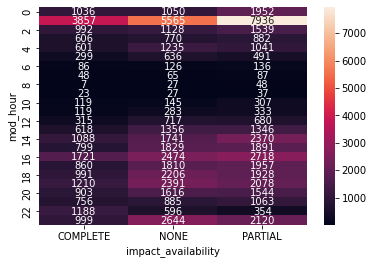

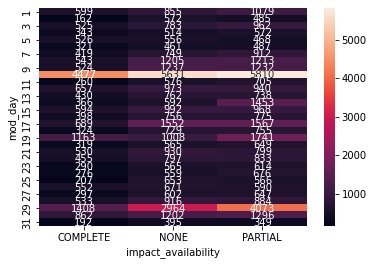

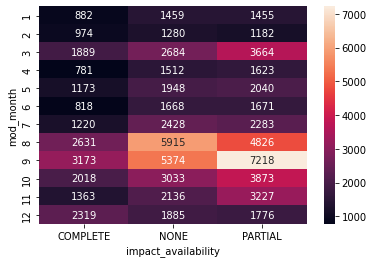

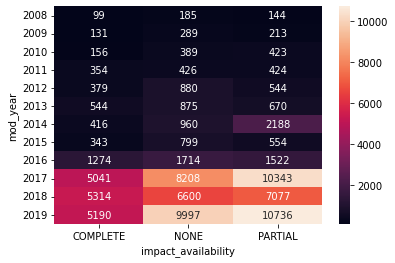

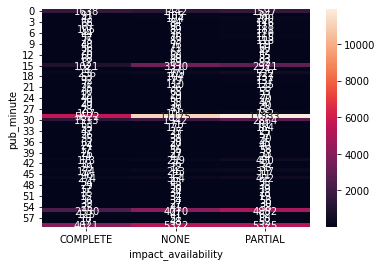

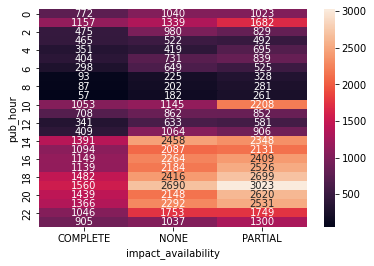

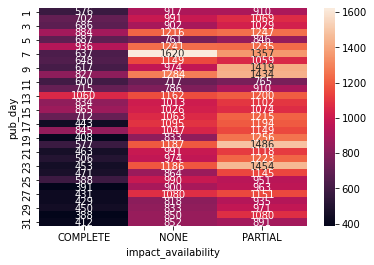

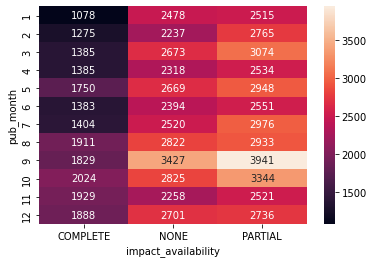

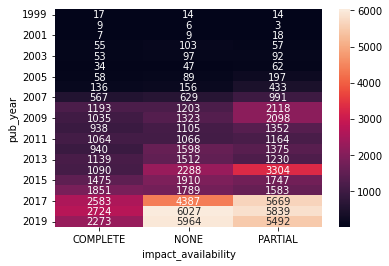

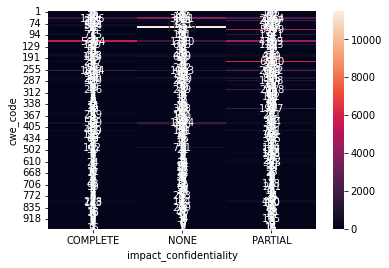

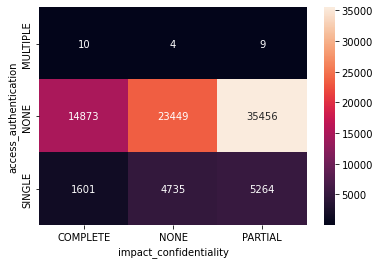

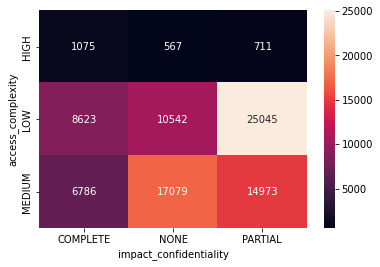

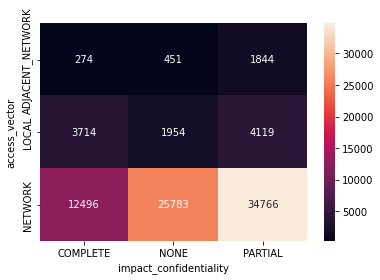

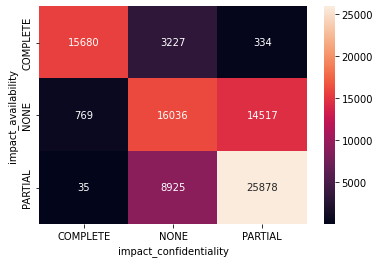

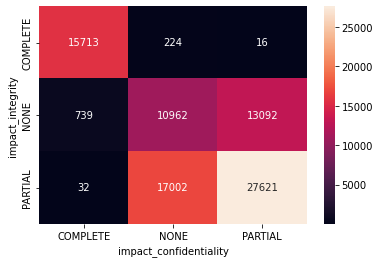

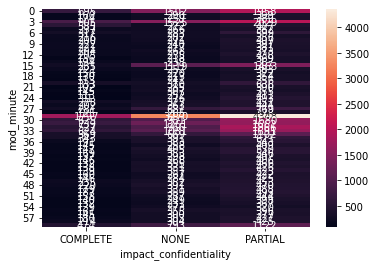

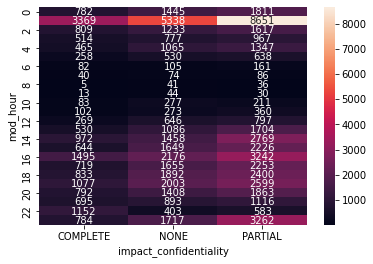

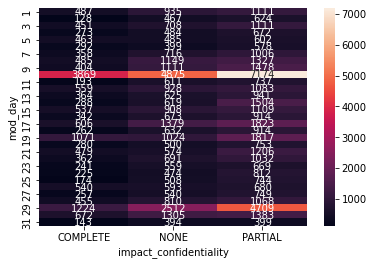

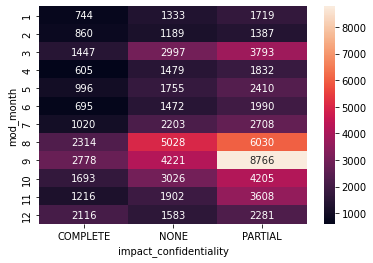

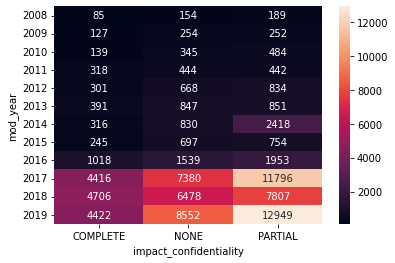

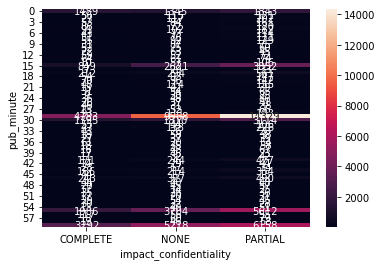

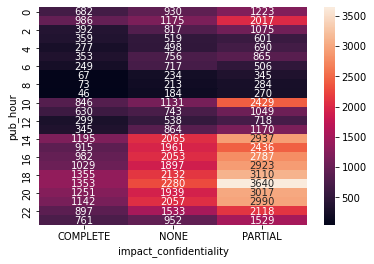

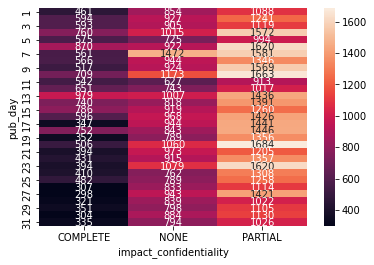

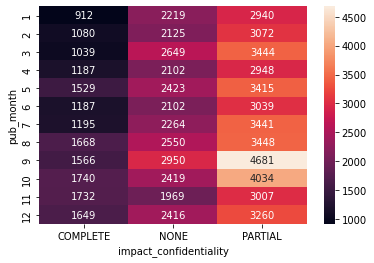

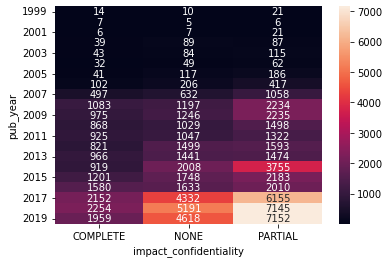

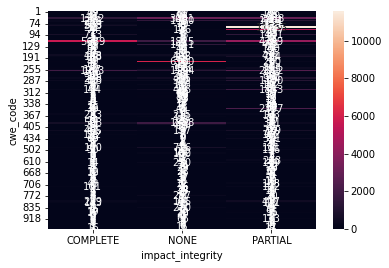

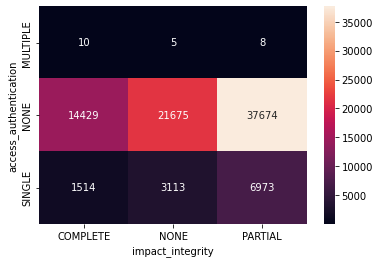

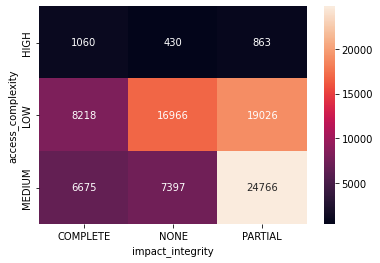

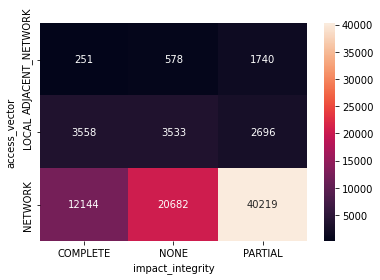

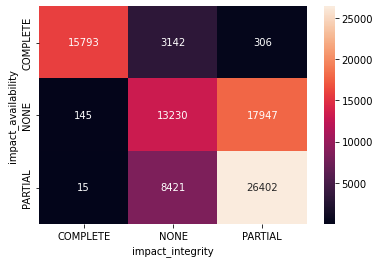

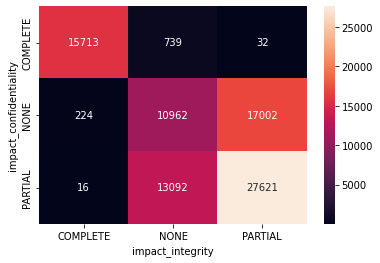

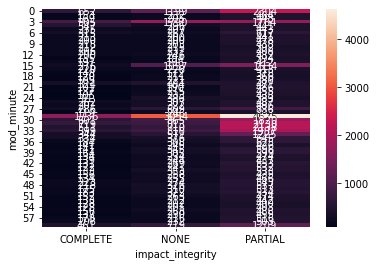

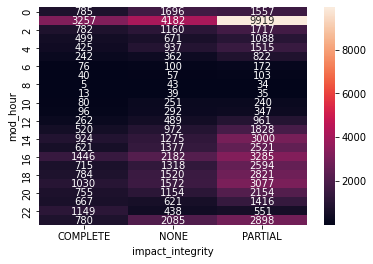

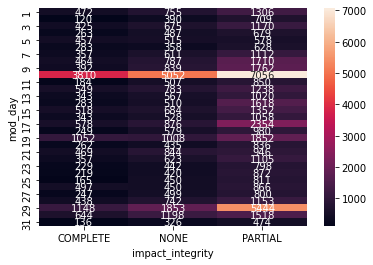

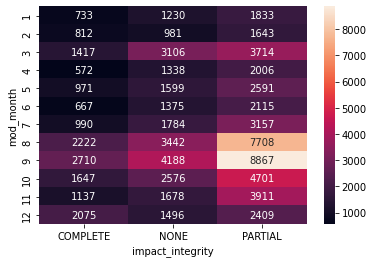

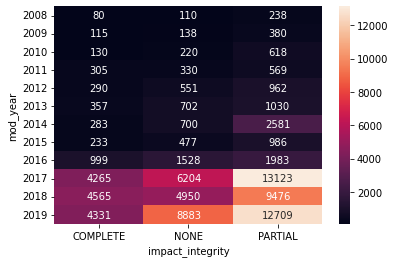

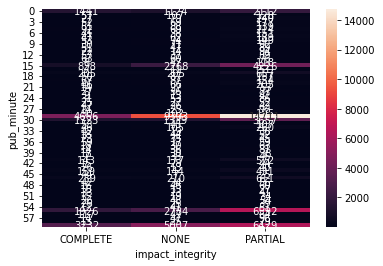

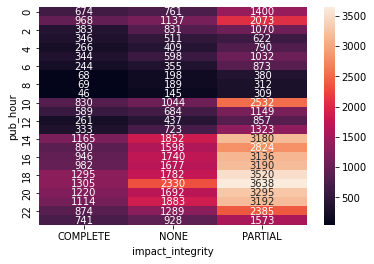

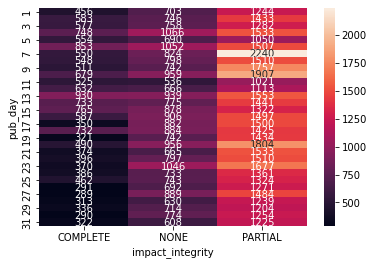

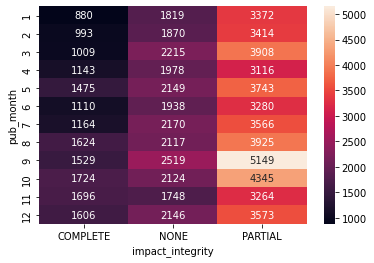

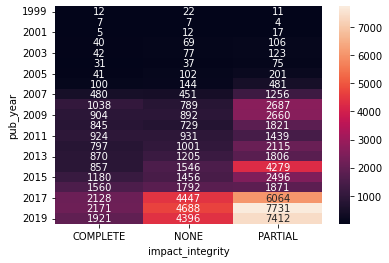

In [57]:
cat_features_display = df_data.select_dtypes(include=['object']).columns
for feature in cat_features_display:
    for feature2 in cat_features:
        if feature2 is not feature:
            plt.figure()
            sns.heatmap(pd.crosstab(df_data[feature2], df_data[feature]), annot=True, fmt='d')
            plt.show()

We notice here several interesting elements in the bivariate analysis of the categorical variables:
- 'access_complexity' and 'access_authentication' have a fairly high correlation, especially with 'NONE' and 'MEDIUM' values of the former around the 'NONE' value of the latter
- access_complexity' and 'impact_availability' have little correlation
- the 'NONE' and 'SINGLE' values of 'access_authentication' are mostly clustered around the 'NETWORK' value of 'access_vector
- there is a strong correlation between 'impact_confidentiality' and 'impact_availability

Thus, the columns starting with 'impact' seem to have similar distributions, as well as those starting with 'access'.

## Correlation between the features and the target

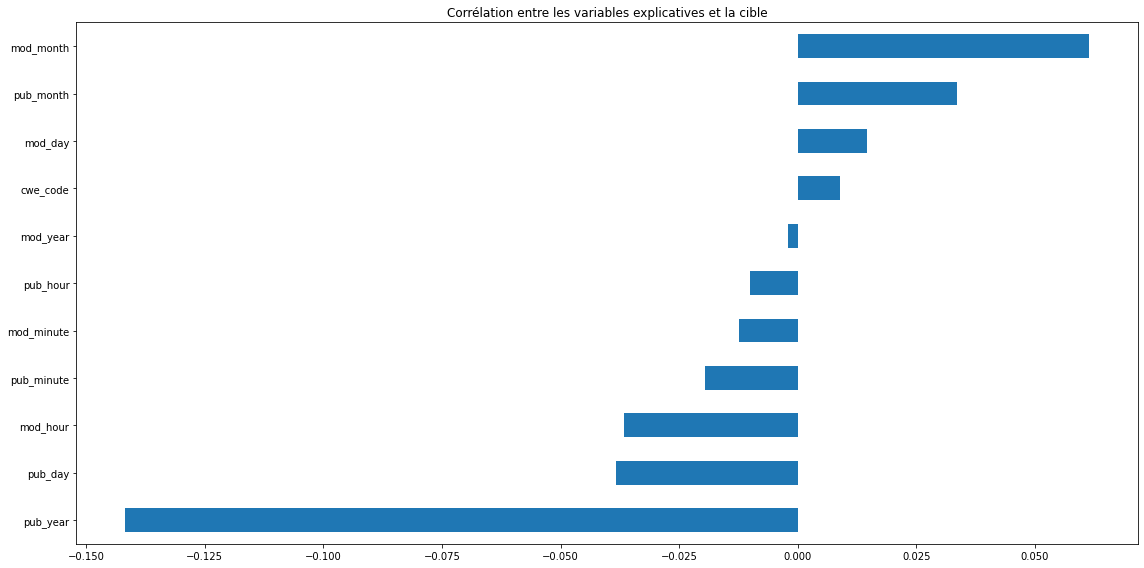

In [58]:
plt.figure(figsize=(16, 8))
corrmat[targetName].sort_values(ascending=True)[:-1].plot(kind='barh')
plt.title("Corrélation entre les variables explicatives et la cible")
plt.tight_layout()
plt.show()

The variables that seem to have the most linear correlation with the target are 'pub_year' and 'mod_month'. Since the year of publication is not very important because it is not cyclical, unlike the month, the first one can be considered as not very interesting. However, if no linear correlation seems strong at first sight, it is possible that a polynomial correlation for example exists.

# Preprocessing

In order to try to find a chain of treatments that would predict the CVSS, it is appropriate to create several versions of the dataset that would be preprocessed differently, before testing them for each model afterwards.

## Target normalization

In [59]:
df_train, df_test = train_test_split(df_data, test_size=0.2, random_state=_RANDOM_STATE_)

The division into two separate sets at the beginning of the pre-processing will allow us to ensure the independence between the training and test sets.

In [60]:
df_train=df_train.reset_index(drop=True)

In [61]:
df_test=df_test.reset_index(drop=True)

In order to avoid problems with certain pre-processing, reset the indexes of the dataframes to zero.

In [62]:
cat_features_display = df_data.select_dtypes(include=['int64','object']).columns
con_features_display = []

In [63]:
# Verifying the shape of the repartition of the target
print("Skewness: %f" %df_train[targetName].skew())
print("Kurtosis: %f" %df_train[targetName].kurt())

Skewness: 0.256461
Kurtosis: -0.679964


We notice that the skewness and kurtosis coefficients confirm that the distribution of the target variable is not normal. It is therefore necessary to perform a log-transformation in order to ensure this necessary condition as explained previously during the exploratory analysis of the data.

In [64]:
# setting up the transformation
loc, scale = norm.fit(df_train[targetName])
n = norm(loc=loc, scale=scale)
print(kstest(df_train[targetName], n.cdf))
# Log transformation
df_train_scaled = df_train.copy()
df_train_scaled[targetName] = np.log1p(df_train[targetName])
df_test_scaled = df_test.copy()
df_test_scaled[targetName] = np.log1p(df_test[targetName])

KstestResult(statistic=0.16435651443511345, pvalue=0.0)


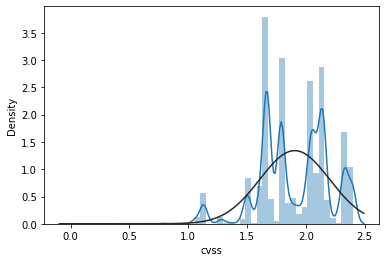

In [65]:
sns.distplot(df_train_scaled[targetName], fit=norm);

In [66]:
print("Skewness: %f" %df_train_scaled[targetName].skew())
print("Kurtosis: %f" %df_train_scaled[targetName].kurt())

Skewness: -0.415541
Kurtosis: 0.010535


We notice here that despite a log transformation of the data, the distribution is not quite normal. However, the coefficients seem better.

If this version of the dataset is used in the future, it will be necessary to think of reversing the log-transformation in order to obtain the true values of the CVSS, because the data range of the target dataset used as input will be modified.

## Preprocessing functions

In [67]:
# Can take for instance StandardScaler, MinMaxScaler, RobustScaler
def scaler(scl, df_train, df_test, con_features = []):
    for feature in con_features:
        df_train[feature] = scl.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = scl.transform(df_test[feature].values.reshape(-1,1)).ravel()
    return df_train, df_test

 A scaler function, as described above, can take as parameter a scaler among StandardScaler, MinMaxScaler and RobustScaler, and then perform a scaling operation on the continuous data of the dataset.

In [68]:
#Can take for instance LabelEncoder, OneHotEncoder
def encoder(ecd, df_train, df_test, cat_features_to_encode = []):
    # If we have one column with two values, we can encode it
    if type(ecd).__name__ != "OneHotEncoder":
        for feature in cat_features_to_encode:
        # The OneHotEncoder feature needs a new shape, instead of the other encoders
            df_train[feature] = ecd.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
            df_test[feature] = ecd.transform(df_test[feature].values.reshape(-1,1)).ravel()
    else:
        for feature in cat_features_to_encode:
            df_train_to_add = pd.DataFrame(ecd.fit_transform(df_train[feature].values.reshape(-1,1)).toarray())
            df_train_to_add.columns = ecd.get_feature_names_out()
            df_train_to_add.columns = [s.replace('x0' , feature) for s in df_train_to_add.columns]
            
            # Adding columns to train
            for serie in df_train_to_add:
                df_train=pd.concat([df_train, df_train_to_add[serie]], axis=1)
            df_train=df_train.drop([feature],axis=1)

            df_test_to_add = pd.DataFrame(ecd.transform(df_test[feature].values.reshape(-1,1)).toarray())
            df_test_to_add.columns = ecd.get_feature_names_out()
            df_test_to_add.columns = [s.replace('x0' , feature) for s in df_test_to_add.columns]
            # Adding columns to test
            for serie in df_test_to_add:
                df_test=pd.concat([df_test, df_test_to_add[serie]], axis=1)
            df_test=df_test.drop([feature],axis=1)
            
    return df_train, df_test

An encoder function can take as parameter an encoder among LabelEncoder and OneHotEncoder, to then perform an encoding operation on the categorical data of the dataset in order to allow their reading by the classification algorithms.

In [69]:
 # Can take for instance KNNImputer, SimpleImputer
def imputer(imp, df_train, df_test, cat_features_to_impute = [], cont_features_to_impute = []):
    # Application de l'imputer sur les variables continues
    for feature in cont_features_to_impute :
        df_train[feature] = imp.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = imp.transform(df_test[feature].values.reshape(-1,1)).ravel()
    # Application de l'imputer sur les variables catégories 
    for feature in cat_features_to_impute :
        df_train[feature] = imp.fit_transform(df_train[feature].values.reshape(-1,1)).ravel()
        df_test[feature] = imp.transform(df_test[feature].values.reshape(-1,1)).ravel()
    return df_train, df_test

An impute function will be able to take as parameter one of KNNImputer and SimpleImputer, to replace missing values of continuous variables (KNN and Simple) as well as categorical values (Simple only).

In [70]:
def preprocessing(df_train, df_test, targetName, scl = None, imp = None, ecd = None):
    # Deep Copy of dataframe to keep the original intact
    df_train_tmp = df_train.copy()
    df_test_tmp = df_test.copy()
    # Using the preprocess
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if imp is None else imputer(imp, df_train_tmp, df_test_tmp, cat_features, con_features)
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if scl is None else scaler(scl, df_train_tmp, df_test_tmp, con_features)
    df_train_tmp, df_test_tmp = [df_train_tmp, df_test_tmp] if ecd is None else encoder(ecd, df_train_tmp, df_test_tmp, cat_features)
    return df_train_tmp, df_test_tmp

The pre-processing function takes in parameter the different pre-processes to apply, by category, then performs one by one the treatments on a copy of the dataset provided in input before returning a new pre-processed version of the training and testing sets. As seen previously, we must impute the missing values (impute and not delete because the number of missing values is negligible). For this, we will use the KNNImputer.

## Creation of the preprocessing combinations

### Simple process

A first suite of simple pre-processing will be used as a basis for comparing the other strings. It must therefore not increase the complexity of the dataframe, while ensuring the basic processing, particularly encoding.

In [71]:
df_train1, df_test1 = preprocessing(df_train_scaled, df_test, targetName, scl = MinMaxScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

In [72]:
df_train1.head()

cvss  cwe_code  access_authentication  access_complexity  \
0  0.747222      39.0                    1.0                1.0   
1  0.747222      39.0                    1.0                1.0   
2  0.695488      12.0                    1.0                2.0   
3  0.695488      12.0                    1.0                2.0   
4  0.695488       5.0                    1.0                2.0   

   access_vector  impact_availability  impact_confidentiality  \
0            2.0                  1.0                     2.0   
1            2.0                  1.0                     2.0   
2            2.0                  1.0                     1.0   
3            2.0                  1.0                     1.0   
4            2.0                  1.0                     1.0   

   impact_integrity  mod_minute  mod_hour  mod_day  mod_month  mod_year  \
0               1.0         1.0      19.0     23.0        9.0       9.0   
1               1.0        44.0      13.0     10.0        0.0      11.0   
2               2.0        30.0      17.0     30.0        2.0       1.0   
3               2.0        28.0      20.0      7.0        4.0      11.0   
4               2.0        15.0       4.0     24.0        6.0      11.0   

   pub_minute  pub_hour  pub_day  pub_month  pub_year  
0        29.0      17.0     18.0        9.0      18.0  
1        15.0      19.0     28.0        9.0      20.0  
2        30.0      17.0     30.0        2.0      10.0  
3        15.0      14.0      7.0        2.0      20.0  
4        15.0      17.0     26.0        5.0      20.0

A first pre-processing will be a MinMaxScaler (simple), and an OrdinalEncoder. This encoder will not split the columns into several binary columns unlike OneHotEncoder, and may cause weight concerns when creating models.

### Simple process with columns deletion

As observed during the exploratory analysis of the data, some columns have little importance and may be counterproductive (such as years because they are not cyclical). It would therefore be interesting to remove the least useful columns in order to verify whether they have a positive impact on the metrics.

In [73]:
df_train2 = df_train_scaled.copy()
df_test2 = df_test_scaled.copy()
df_train2 = df_train2.drop(['pub_year', 'mod_year'], axis=1)
df_test2 = df_test2.drop(['pub_year', 'mod_year'], axis=1)

In [74]:
df_train2, df_test2 = preprocessing(df_train_scaled, df_test, targetName, scl = StandardScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))

We can also select the K best features among the remaining ones using the SelectKBest method.

                   Feature        Score
6         impact_integrity  8914.226212
5   impact_confidentiality  6596.936578
3            access_vector  3870.870270
4      impact_availability  3595.843911
1    access_authentication  2160.657191
16                pub_year  1413.535053
2        access_complexity   737.473694
10               mod_month   280.332642
8                 mod_hour   125.348486
14                 pub_day    71.231978


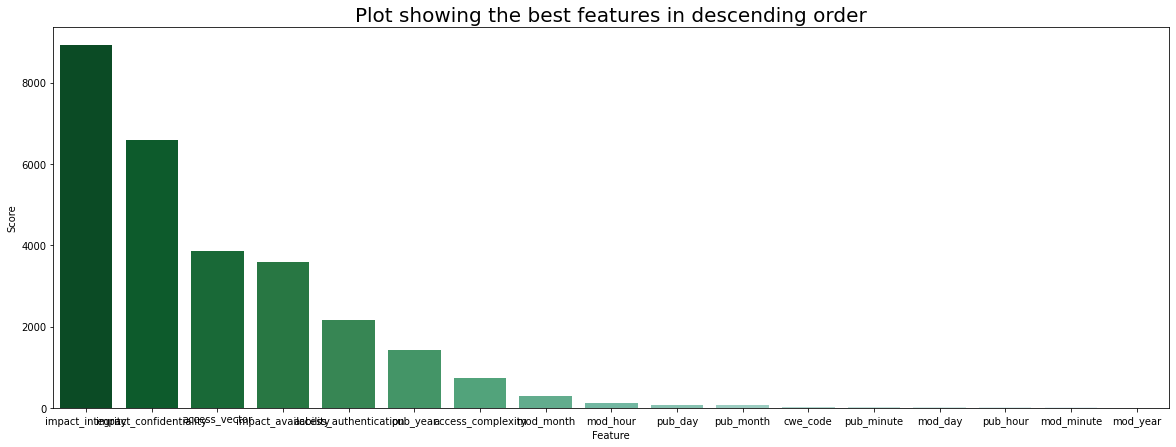

In [75]:
# Cutting the dataset for the selector
df_train_select = df_train2.drop(targetName, axis=1)
target_train = df_train2[targetName]
# Using it and getting n variables
n = 10
select = SelectKBest(score_func=f_regression, k=n)
z = select.fit_transform(df_train_select, target_train)
# Getting the scores
selection_scores = pd.DataFrame(select.scores_)
data_columns = pd.DataFrame(df_train_select.columns)
# Concatenating both dataframes
scores = pd.concat([data_columns,selection_scores],axis=1)
scores.columns=['Feature','Score']
print(scores.nlargest(n,'Score'))
# Showing the result
scores = scores.sort_values(by="Score", ascending=False)
plt.figure(figsize=(20,7), facecolor='w')
sns.barplot(x='Feature',y='Score',data=scores,palette='BuGn_r')
plt.title("Plot showing the best features in descending order", size=20)
plt.show()

We notice here that a minority of columns have an impact on the value of the regression, so we can try to keep only the top 10 impacting values.

In [76]:
to_keep = np.array(scores.nlargest(10,'Score')["Feature"])
to_keep = np.append(to_keep,targetName)
df_train2 = df_train2[to_keep]
df_test2 = df_test2[to_keep]

In [77]:
df_train2.head()

impact_integrity  impact_confidentiality  access_vector  \
0               1.0                     2.0            2.0   
1               1.0                     2.0            2.0   
2               2.0                     1.0            2.0   
3               2.0                     1.0            2.0   
4               2.0                     1.0            2.0   

   impact_availability  access_authentication  pub_year  access_complexity  \
0                  1.0                    1.0      18.0                1.0   
1                  1.0                    1.0      20.0                1.0   
2                  1.0                    1.0      10.0                2.0   
3                  1.0                    1.0      20.0                2.0   
4                  1.0                    1.0      20.0                2.0   

   mod_month  mod_hour  pub_day      cvss  
0        9.0      19.0     18.0 -0.382681  
1        0.0      13.0     28.0 -0.382681  
2        2.0      17.0     30.0 -0.799447  
3        4.0      20.0      7.0 -0.799447  
4        6.0       4.0     26.0 -0.799447

### Complex encoded process

A more complex processing chain will limit the impact of the weights of the first method, without worrying about the complexity and size of the dataframe.

In [78]:
df_train3, df_test3 = preprocessing(df_train_scaled, df_test_scaled, targetName, scl = StandardScaler(), imp = SimpleImputer(strategy="most_frequent"), ecd = OneHotEncoder(handle_unknown='ignore'))

In [79]:
df_train3.head()

cvss  cwe_code_1  cwe_code_16  cwe_code_17  cwe_code_18  cwe_code_19  \
0 -0.382681         0.0          0.0          0.0          0.0          0.0   
1 -0.382681         0.0          0.0          0.0          0.0          0.0   
2 -0.799447         0.0          0.0          0.0          0.0          0.0   
3 -0.799447         0.0          0.0          0.0          0.0          0.0   
4 -0.799447         0.0          0.0          0.0          0.0          0.0   

   cwe_code_20  cwe_code_21  cwe_code_22  cwe_code_59  cwe_code_74  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          1.0          0.0          0.0          0.0          0.0   

   cwe_code_77  cwe_code_78  cwe_code_79  cwe_code_88  cwe_code_89  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          1.0          0.0          0.0   
3          0.0          0.0          1.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   cwe_code_90  cwe_code_91  cwe_code_93  cwe_code_94  cwe_code_99  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   cwe_code_113  cwe_code_116  cwe_code_118  cwe_code_119  cwe_code_120  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_123  cwe_code_125  cwe_code_129  cwe_code_131  cwe_code_134  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_172  cwe_code_178  cwe_code_184  cwe_code_185  cwe_code_189  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_190  cwe_code_191  cwe_code_193  cwe_code_199  cwe_code_200  \
0           0.0           0.0           0.0           0.0           1.0   
1           0.0           0.0           0.0           0.0           1.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_203  cwe_code_209  cwe_code_216  cwe_code_252  cwe_code_254  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           0.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           0.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   cwe_code_25

In [80]:
df_train3.shape

(71624, 473)

A third combination of preprocesses introduces the OneHotEncoder. This explodes the categorical columns into binary columns, so that the integer value of the labels does not impact the results of some modeling, where larger integer values than others could have a higher weight, while these integers are only encodings of categories.

# Modelization

Now that the data are pre-processed, they can be used to create models that answer our initial problem. To improve our results as much as possible, we will create several models, then we will determine the performance of each model. We will also have to use each pre-process on each model, in order to determine the best data processing chain.

In [81]:
def testModel(df_train, df_test, targetName, model, showMetrics = False):
    # Separation of the target from the features
    y_train =  df_train[targetName]
    y_test =  df_test[targetName]
    X_train = df_train.drop(targetName, axis=1)
    X_test = df_test.drop(targetName, axis=1)
    # Fitting the model
    model.fit(X_train, y_train)
    # Getting the results on both the training set and the testing set
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    # Calculating the metrics and displaying them
    rmse=np.sqrt(mean_squared_error(y_test, y_pred_test))
    mae=mean_absolute_error(y_test, y_pred_test)
    medae=median_absolute_error(y_test, y_pred_test)
    print("--> rmse =", rmse)
    print("--> mae =", mae)
    print("--> medae =", medae)
    # This representative metric can be changed if needed
    toReturn = medae
    if showMetrics:
        N, train_score, val_score = learning_curve(model, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=5, 
                                                  scoring='neg_mean_squared_error',
                                                  train_sizes=np.linspace(0.1, 1, 10))
        plt.figure(figsize=(14,7))
        plt.title("Learning curve of the model: " + str(model.__class__.__name__))
        plt.plot(N, train_score.mean(axis=1), label='Train Score')
        plt.plot(N, val_score.mean(axis=1), label='Validation Score')
        plt.legend()
        
    return toReturn

The testModel function allows to apply an instantiated model passed in parameter to the data of a pre-processed dataset also passed in parameter. It will then be very easy to loop over all the models and pre-processings in order to compare them and thus to obtain the best chain of pre-processings and the best model.

The 3 metrics chosen to evaluate the models are :
- root mean square error, which is the square root of the calculated variance
- mean absolute error, which determines the average distance between the predicted results and the true value
- median absolute error, which determines the median distance separating the predicted results from the true value

In order to avoid outliers, we prefer to use the median here.

In [82]:
 def getBestChain(l_preprocess, l_models):
    chosen = None
    tableResult = []
    print("Training")
    for p in l_preprocess:
        print("> Using preprocess:", p)
        df_train = l_preprocess[p]["train"]
        df_test = l_preprocess[p]["test"]
        targetName = l_preprocess[p]["target"]
        for m in l_models:
            print("-> Training on model:", m)
            result = {"model": m, "preprocess": p}
            result["score"] = testModel(df_train, df_test, targetName, l_models[m], showMetrics = False)
            tableResult.append(result)
    tableResult = sorted(tableResult, key=lambda d: d['score'], reverse=True)
    print(tableResult)
    return tableResult[0]

The getBestChain function will iterate over all preprocesses and models to find the best processing chain, with the median absolute error as the reference for the metric.

In [83]:
# Pré-traitements à tester
l_preprocess = {"1": {"train": df_train1, "test": df_test1, "target": targetName},
                "2": {"train": df_train2, "test": df_test2, "target": targetName},
                "3": {"train": df_train3, "test": df_test3, "target": targetName}}
# Modèles à tester
l_models = {"Ridge": Ridge(random_state=_RANDOM_STATE_),
            "Ridge06": Ridge(alpha=0.06, random_state=_RANDOM_STATE_),
            "Ridge10": Ridge(alpha=10, random_state=_RANDOM_STATE_),
            "Lasso": Lasso(),
            "LinearSVR": LinearSVR(random_state=_RANDOM_STATE_),
            # "SVR" : SVR(), # Very long to execute + no impressive results
            "SGDRegressor" : SGDRegressor(random_state=_RANDOM_STATE_),
            "GradientBoostingRegressor" : GradientBoostingRegressor(random_state=_RANDOM_STATE_),
            "RandomForestRegressor": RandomForestRegressor(random_state=_RANDOM_STATE_),
            "LinearRegression": LinearRegression()
            }
bestResult = getBestChain(l_preprocess, l_models)

Training
> Using preprocess: 1
-> Training on model: Ridge
--> rmse = 1.9025306057114988
--> mae = 1.7242452115649627
--> medae = 1.662370996227533
-> Training on model: Ridge06
--> rmse = 1.9025300813867134
--> mae = 1.7242451667815806
--> medae = 1.6623722667608867
-> Training on model: Ridge10
--> rmse = 1.90253562200261
--> mae = 1.7242456400419854
--> medae = 1.6623588329742605
-> Training on model: Lasso
--> rmse = 1.9170782150770287
--> mae = 1.7256380970084615
--> medae = 1.6240631159767067
-> Training on model: LinearSVR
--> rmse = 2.001655082191505
--> mae = 1.8302723235274512
--> medae = 1.8202729692135438
-> Training on model: SGDRegressor
--> rmse = 1114475927.8876984
--> mae = 889625756.8276603
--> medae = 759826967.6410962
-> Training on model: GradientBoostingRegressor
--> rmse = 1.8692201701736617
--> mae = 1.72372571138184
--> medae = 1.6631306949110445
-> Training on model: RandomForestRegressor
--> rmse = 1.8674680571386209
--> mae = 1.7241079997086237
--> medae = 1

The results vary enormously according to the pre-processing, and a little less according to the models. However, we locate here a processing chain that reduces the absolute median error: random forest with the 3rd pre-processing chain.

We can now try to improve the results obtained by optimizing the parameters of the latter.

# Evaluation

In order to check if the model is not overfitted, we can display its learning curve.

In [84]:
def evaluation(model, X_train, y_train, X_test, y_test):
    N, train_score, val_score = learning_curve(model, 
                                              X_test, 
                                              y_test, 
                                              cv=5, 
                                              scoring='neg_mean_squared_error',
                                              train_sizes=np.linspace(0.1, 1, 5))
    plt.figure(figsize=(14,7))
    plt.title("Learning curve of the model: " + str(model.__class__.__name__))
    plt.plot(N, train_score.mean(axis=1), label='Train Score')
    plt.plot(N, val_score.mean(axis=1), label='Validation Score')
    plt.legend()
    
    

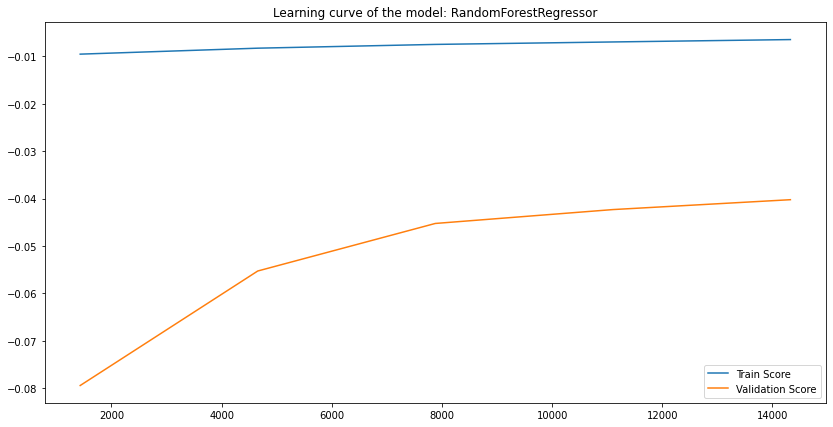

In [85]:
X_train = df_train3.drop(targetName, axis = 1)
y_train = df_train3[targetName]

X_test = df_test3.drop(targetName, axis = 1)
y_test = df_test3[targetName]
model = RandomForestRegressor(random_state=_RANDOM_STATE_)
evaluation(model, X_train, y_train, X_test, y_test)

We notice here that the model is not overfitting, which is positive for our problem. Indeed, the two curves seem to converge, and the validation curve has a strictly increasing score, which means that the results on the validation set are improving. However, we can restart this evaluation by passing the testing set, which is 4 times larger than the testing set, as a parameter, if more computational resources are available.

# Optimization

In order to further improve the results, it is possible to perform a parameter optimization on the chosen model. Here, it is possible to optimize various parameters of RandomForestRegressor:
- n_estimators, the number of trees per forest, thus the number of estimators
- max_depth, the maximum depth of each tree (risk of being exponential in complexity)
- min_samples_split, minimum number of samples in the dataset to cut the experiment into a new node

Other even more precise parameters can also be optimized. However, here, we will limit ourselves to the number of estimators, because otherwise the duration of the experiment would be too long (hardware limit).

In [86]:
def optimisation(model, x_train, y_train, param_opti, metric, interv_min, interv_max, pas):
    param_grid={param_opti:  np.arange(interv_min, interv_max, pas)}
    
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring=metric)
    grid.fit(x_train, y_train)
    print("Best score est: ", grid.best_score_)
    print("Best value of the optimized parameter: ", grid.best_params_)
    
    param_range = np.arange(interv_min, interv_max, pas)
    
    train_score, val_score = validation_curve(model, 
                                              x_train,
                                              y_train,
                                              param_name=param_opti, 
                                              param_range=param_range, 
                                              cv=5,
                                             scoring=metric)

    plt.figure(figsize=(12, 4))
    plt.plot(param_range, train_score.mean(axis = 1), label = 'train')
    plt.plot(param_range, val_score.mean(axis = 1), label = 'validation')
    plt.legend()
    plt.title("Validation curve for " + str(model.__class__.__name__))
    plt.ylabel('score')
    plt.xlabel('Regularization parameter: '+param_opti)
    plt.show()
    
    return grid.best_estimator_

In [90]:
grid_result = optimisation(model, X_train, y_train, "n_estimators", "r2", 10, 500, 100)

Because it is too long to execute on my computer, I haven't executed this part. However, simply uncomment it if time is not a problem.

# Conclusion

In conclusion, the dataset is unfortunately quite noisy and few strong correlations appear with the target value. However, we were able to perform a chain of treatments giving satisfactory results, with a confidence of about 2%. The use of OneHotEncoder increases the complexity, the training times of the models are multiplied, but allow to give very good results for the majority of the models, moreover with RandomForestRegressor.

We can also propose some improvement tracks:
- Add new models
- Add new pre-processing
- Introduce NLP on the summary column with a Tensorflow model
- Try the class approach (classification)
- Improve the quality of the dataset